# Spatial-DC: a robust deep learning-based method for deconvolution of spatial proteomics
This analysis workflow demostreates the workflow for deconvolution of antibody-derived DNA tags (ADTs)-based spatial proteomics data by Spatial-DC.

[![python >3.9.20](https://img.shields.io/badge/python-3.9.20-brightgreen)](https://www.python.org/)

## Here is a demo code on python envirment to the assessment of Spatial-DC on Human Palatine Tonsil data.

In [1]:
# Load necessary packages
import os
import sys
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
from scipy import stats
# import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import warnings
warnings.filterwarnings("ignore")

print(sys.version)
# plt.rcParams['font.size'] = 10
# plt.rcParams['pdf.fonttype'] = 42
# plt.rcParams['ps.fonttype'] = 42

3.9.20 | packaged by conda-forge | (main, Sep 30 2024, 17:49:10) 
[GCC 13.3.0]


In [2]:
# set the working directory
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/code_data_availability/Spatial_DC_V1")
dataset_dir = "datasets/human_palatine_tonsil"
scaler = MinMaxScaler(feature_range=(0, 1))

## Overview of reference data and spatial proteomics data.

In [3]:
# Overview the reference proteomics data
sc_adata = sc.read_h5ad(f"{dataset_dir}/intersected_reference_proteomics.h5ad")
# ct_order = ["C10","RAW","SVEC"] # define the order of cell types

print(f"Protein count: {sc_adata.to_df().iloc[0:4,0:4]}\n")
print(f"The number of cells: {sc_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", sc_adata.shape)

Protein count: name2   B7H4  CD10  CD101  CD103
cell_1   5.0   1.0    2.0    2.0
cell_2   4.0   5.0    0.0    0.0
cell_3   1.0  19.0    2.0    1.0
cell_4   2.0  10.0    0.0    2.0

The number of cells: celltype
CD4 T            4188
NBC              3132
Naive CD4 T      2956
GCBC             2836
MBC              1733
CD8 T             628
Activated NBC     540
Naive CD8 T       463
PC                289
cycling T         172
DC                102
PDC                85
DN                 58
NK                 56
Mono/Macro         44
ILC                42
FDC                19
epithelial         13
Granulocytes       11
Name: count, dtype: int64

The total cells and intersected proteins: (17367, 174)


In [4]:
ct_order = ['Activated NBC','NBC','GCBC','MBC', 'PC', # 5 PC, Plasma cells; B
              'cycling T', 'DN','ILC','NK',#NK   #4 DN, double-negative T cells with a profile of proinflamatory activation
              'CD4 T', 'Naive CD4 T', #2
              'CD8 T','Naive CD8 T',  #2                            
              'DC','PDC', 'FDC',  #3 PDC, plasmactyoid DC; DC
              'Mono/Macro','Granulocytes',  #2 MO
              'epithelial' # 1 Epi and ILC
       ]

In [5]:
# Overview the spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/intersected_spatial_proteomics.h5ad")
print(f"Protein count: {sp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", sp_adata.shape)

Protein count: name2   B7H4  CD10  CD101  CD103
spot_1     3     3      5      0
spot_2     2     2      8      0
spot_3     1     4      2      0
spot_4     1     1      3      0

The total spots and intersected proteins: (2492, 174)


In [6]:
# Load Intersection of reference and spatial datasets
intersect = np.intersect1d(sc_adata.var_names, sp_adata.var_names)        
sp_adata = sp_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()

sc.pp.normalize_total(sc_adata)
sc.pp.normalize_total(sp_adata)

print(sc_adata.shape)
print(sp_adata.shape)

(17367, 174)
(2492, 174)


## Create deconvolution model and load trained DIS model

In [7]:
# Load Spatial-DC package
from Spatial_DC_beta import SpatialDC

# conda install pytorch-cluster -c pyg

# Load trained DIS model
model_path = f"trained_model/human_palatine_tonsil/model_epoch200.pt"

spatial_dc = SpatialDC(sc_adata=sc_adata, sp_adata=sp_adata, print_info=True) 
spatial_dc.load_distribution_model(load_model_path = model_path)
pred_sp_adata = spatial_dc.transfer_distribution_model()

In [8]:
pred_sp_adata.uns["cellperc_initial"].iloc[0:4,0:4] # Overview of the intermediate cell percentages

Activated NBC     CD4 T  CD8 T   DC
spot_1       0.239667  0.217205    0.0  0.0
spot_2       0.000000  0.000000    0.0  0.0
spot_3       0.000000  0.000000    0.0  0.0
spot_4       0.000000  0.000000    0.0  0.0

In [9]:
# Traine the self-supvervised model
spatial_dc.setup_reconstruction_model(k_graph=30, epochs=200)
refined_sp_adata = spatial_dc.reconstruct()

Training: 100%|██████████| 200/200 [01:15<00:00,  2.64epoch/s, loss=4.13125]


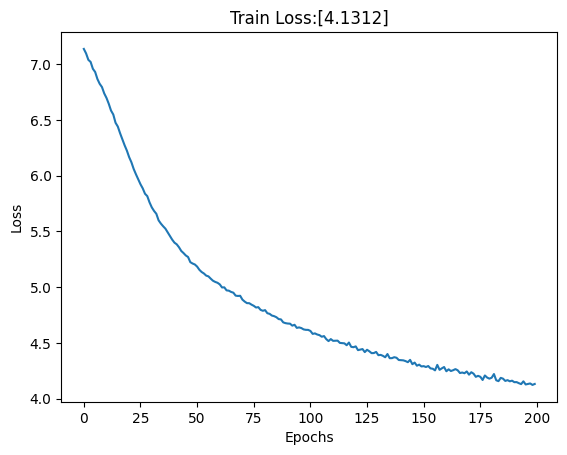

In [10]:
# print the train loss of SSM model
train_loss = spatial_dc.reconstruction_model.state["train_loss"]
epochs = spatial_dc.reconstruction_model.state["epochs"]
        
plt.plot(np.arange(0,epochs), train_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Train Loss:[{"%.4f" % train_loss[-1]}]')
plt.show()
plt.close()   

In [11]:
# print the refined cell-type composition
pred_ct = pred_sp_adata[sp_adata.obs.index].uns["cellperc_reconstruct"][ct_order]
print("Here is the predicted cell-type composition:")
print(pred_ct.iloc[0:10,0:4])

Here is the predicted cell-type composition:
         Activated NBC       NBC      GCBC       MBC
spot_1        0.252806  0.227114  0.173375  0.000000
spot_2        0.000000  0.000000  0.000000  0.000000
spot_3        0.000000  0.000000  0.000000  0.000000
spot_4        0.000000  0.000000  0.000000  0.019705
spot_5        0.000000  0.000000  0.000000  0.000000
spot_6        0.000000  0.000000  0.000000  0.000000
spot_7        0.000000  0.000000  0.000000  0.000000
spot_8        0.000000  0.000000  0.000000  0.000000
spot_9        0.000000  0.000000  0.000000  0.000000
spot_10       0.000000  0.000000  0.000000  0.000000


Here is the predicted cell-type composition


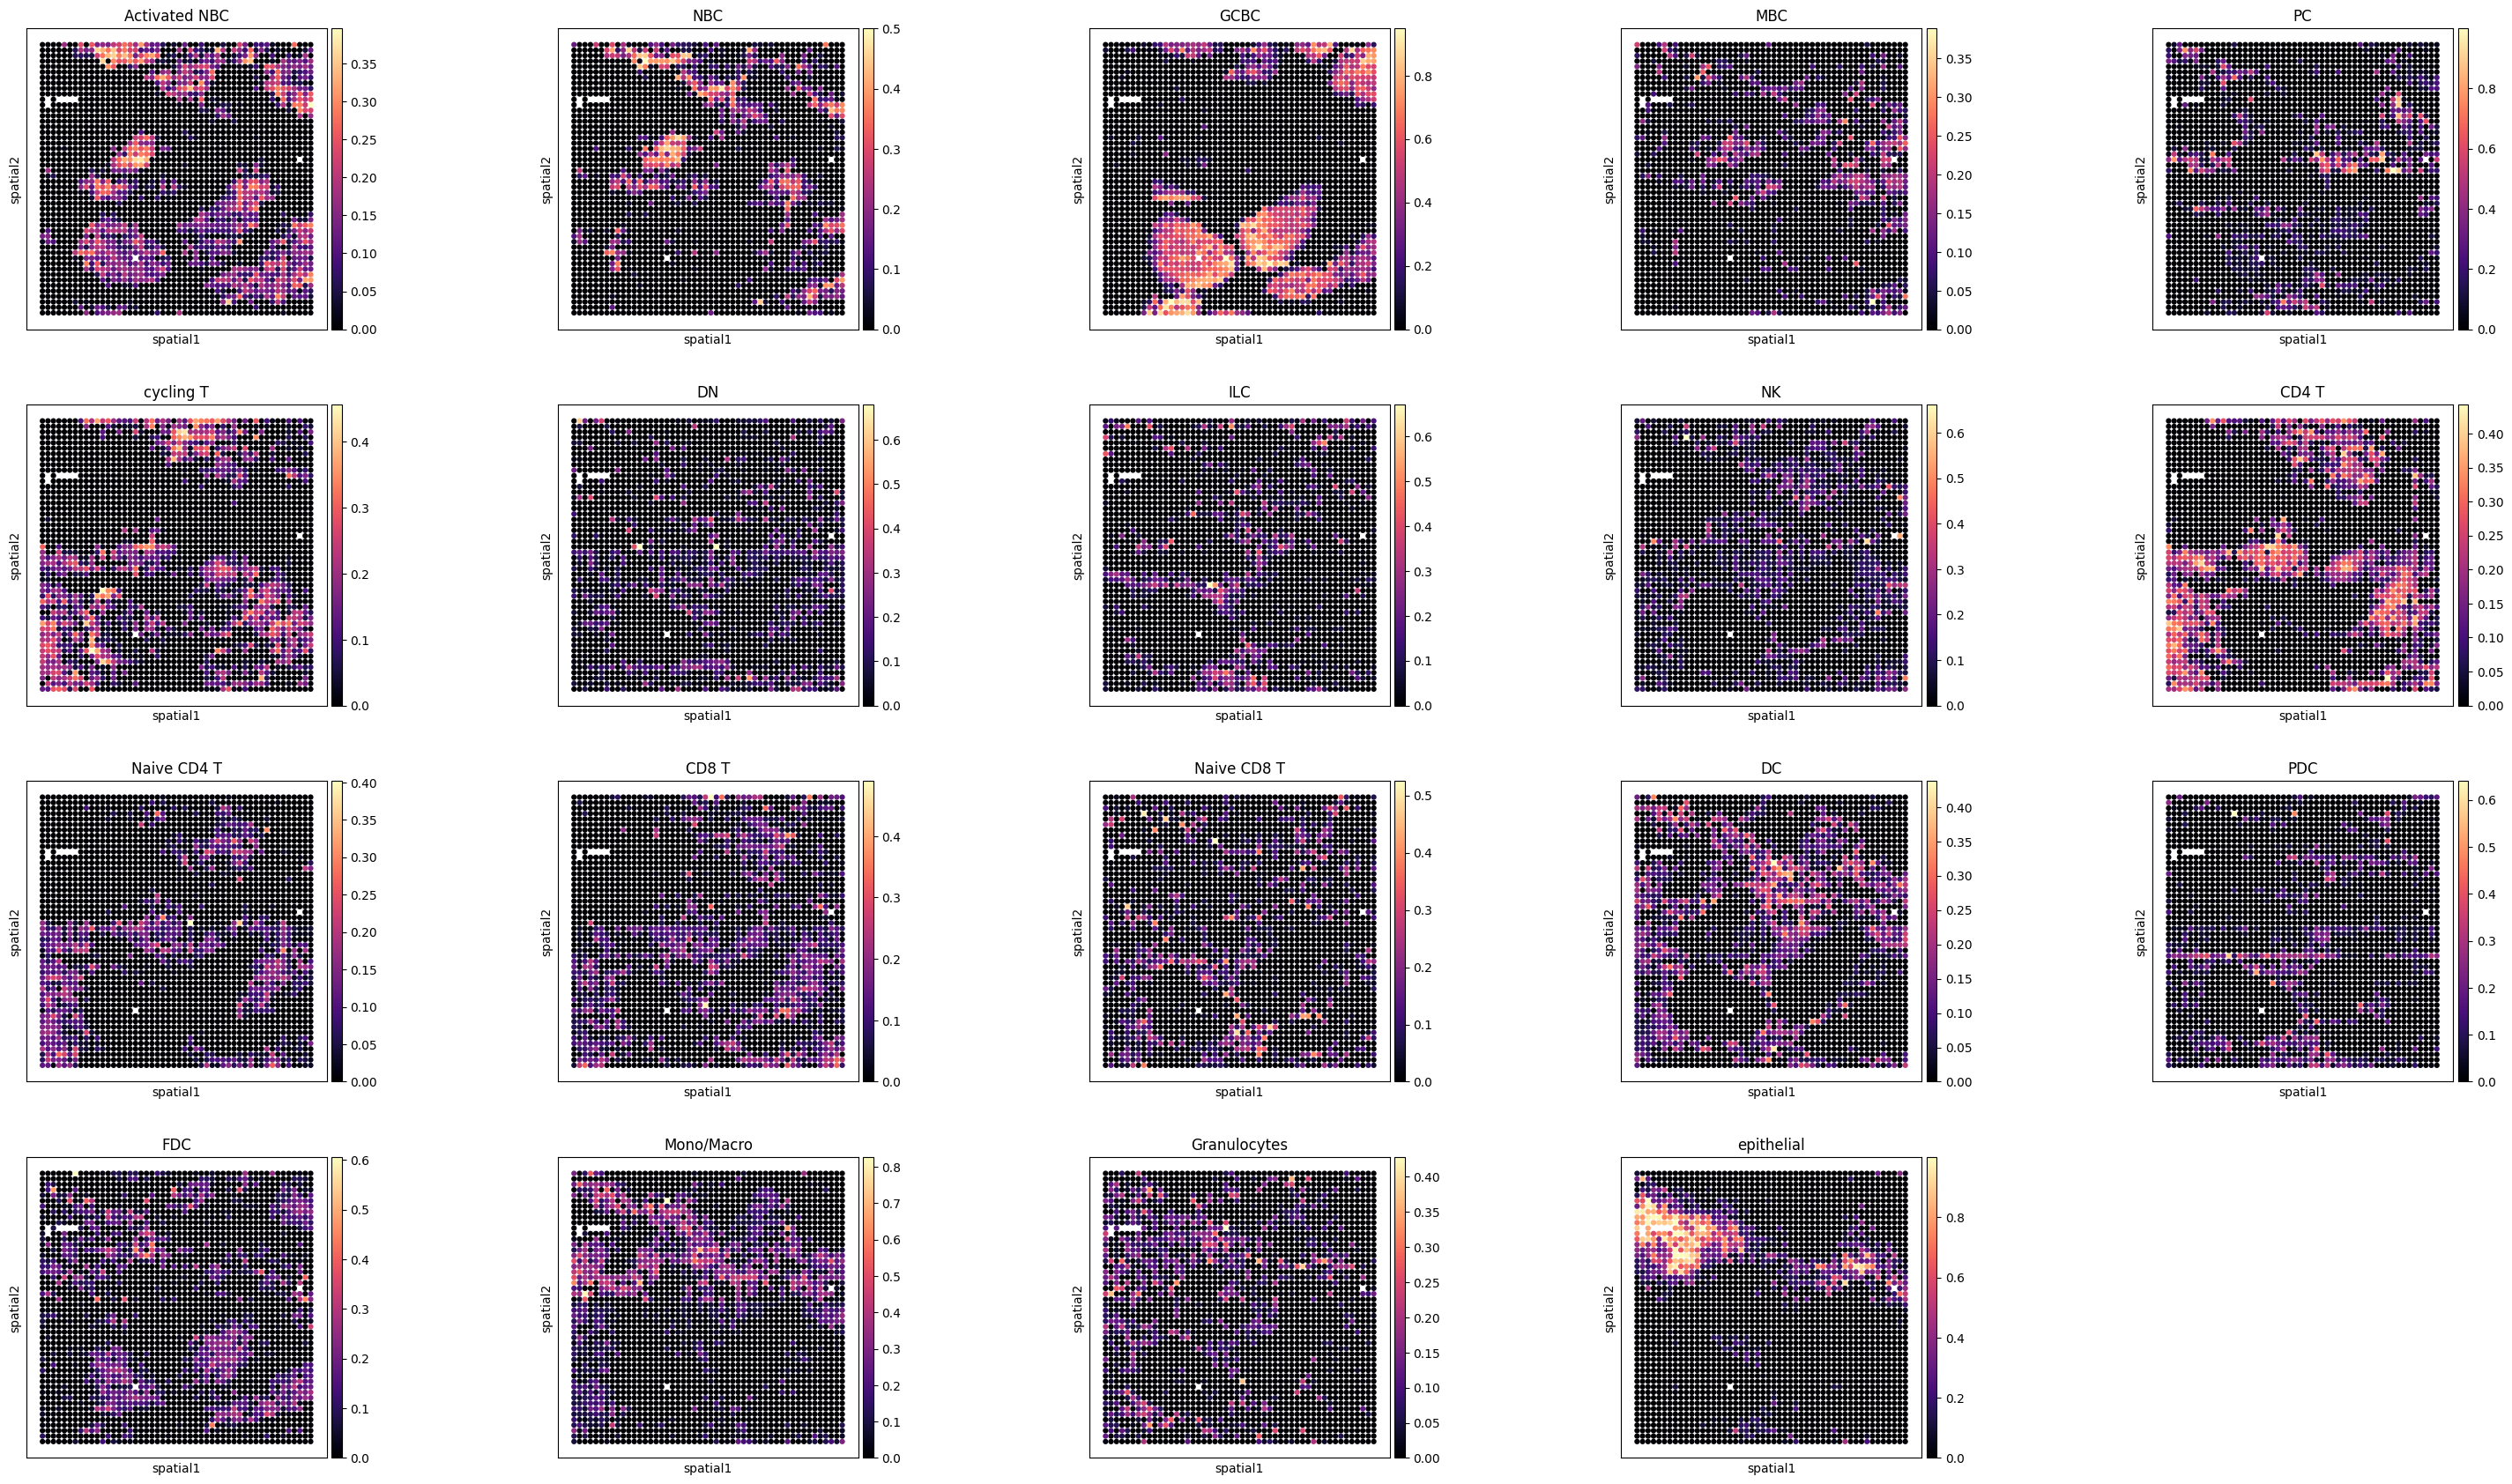

In [12]:
# Plot the distribution of predicted cell-type composition
sp_adata.obs = pred_ct[ct_order]
print("Here is the predicted cell-type composition")
sc.pl.spatial(sp_adata,spot_size=1,color=ct_order,color_map="magma",ncols=5,wspace=0.15)

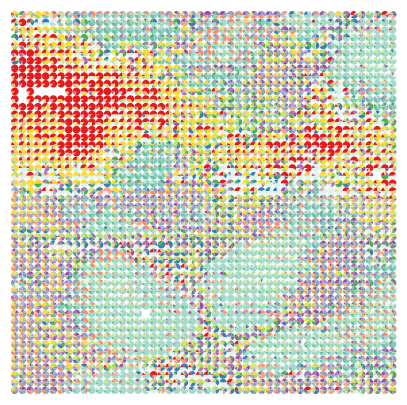

In [13]:
# visualization of cell-type composition as Pie plot
my_palette = [
    "#66C2A5", "#84CEB7", "#A3DAC9", "#C2E6DB", "#E1F3ED", # B
    "#FC8D62", "#FCA481", 
    "#377EB8",#ILC
     "#4DAF4A",  #NK 
    "#8DA0CB", "#A4B3D5", # T4
    "#984EA3", "#AC71B5", # T8
    "#A6D854", "#B7DF76", "#C9E799",#DC
    "#FFD92F", "#E5C494", #MO and GN
    "#E41A1C", #Epi
    ]

spatial = pd.DataFrame(sp_adata.obsm['spatial'], index=sp_adata.obs_names,columns=["x","y"])

fig, axs = plt.subplots(50, 50, figsize=(5, 5))
plt.subplots_adjust(hspace=-0.2, wspace=-0.2)  # 调整这里的值来缩小间距  

for i in range(50):  
    for j in range(50): 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].axis('off')
        
for spot_num in range(spatial.shape[0]):
    i = spatial["y"][spot_num] - 1
    j = spatial["x"][spot_num] - 1
    
    
    axs[i, j].pie(np.array(pred_ct[ct_order])[spot_num], colors=my_palette,radius=0.01, wedgeprops=dict(width=1, edgecolor='none'))
    axs[i, j].set_aspect('equal', 'box')
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

plt.show()

## Assessment of reconstructing cell-type proteomic profiles by Spatial-DC from representative synthetic NSCLC data

Protein intensity: name2                     B7H4       CD10      CD101  CD103
ID                                                         
spot_1_Activated NBC  3.753709   4.004475   0.000000    0.0
spot_1_CD4 T          2.688635   1.737697  30.100312    0.0
spot_1_GCBC           4.637087  11.943830   0.000000    0.0
spot_1_NBC            4.149900   0.625444   0.000000    0.0

The total spots and intersected proteins: (16680, 174)
The number of cells: celltype
DC               1098
CD8 T            1069
Mono/Macro       1067
NK               1061
CD4 T            1024
cycling T         991
FDC               985
Activated NBC     975
DN                899
Naive CD8 T       844
GCBC              839
Granulocytes      830
PC                790
Naive CD4 T       786
ILC               736
PDC               728
NBC               703
epithelial        656
MBC               599
Name: count, dtype: int64

The total cells and intersected proteins: (16680, 174)


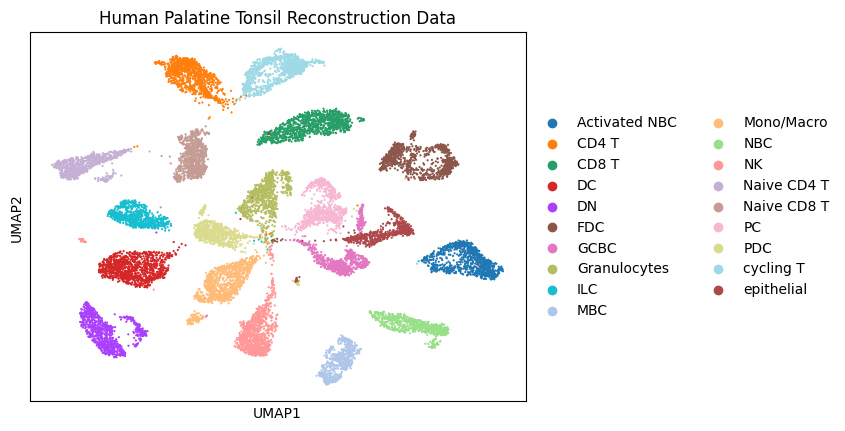

In [14]:
# Obtain the reconstructed adata from trained SSM
rec_scp_adata = spatial_dc.purify_spots(norm=True, spatial_info=True)

# UMAP of reconstructed adata
rec_scp_adata = rec_scp_adata[rec_scp_adata.obs["cellperc"] > 0,:]

print(f"Protein intensity: {rec_scp_adata.to_df().iloc[0:4,0:4]}\n")
print("The total spots and intersected proteins:", rec_scp_adata.shape)

print(f"The number of cells: {rec_scp_adata.obs['celltype'].value_counts()}\n")
print("The total cells and intersected proteins:", rec_scp_adata.shape)

sc.pp.normalize_total(rec_scp_adata)
sc.pp.log1p(rec_scp_adata)
sc.pp.scale(rec_scp_adata)
sc.pp.pca(rec_scp_adata)
sc.pp.neighbors(rec_scp_adata)
sc.tl.umap(rec_scp_adata)
sc.pl.umap(rec_scp_adata, color=["celltype"], size=10, title="Human Palatine Tonsil Reconstruction Data")